Projeto realizada para o Desafio de Machine Learnig no Bootcamp Geração Tech Unimed-BH - Ciência de Dados / DIO.
O desafio consiste em desenvolver um projeto em aplicar o método de Transfer Learning em uma rede de Deep Learning na linguagem Python no ambiente COLAB.

In [49]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from tensorflow.keras.preprocessing import image

## Obtendo um conjunto de dados
Primeiro passo será carregar nossos dados.



In [50]:
# wget https://www.microsoft.com/en-us/download/details.aspx?id=54765 
# gunzip -xvzf kagglecatsanddogs_5340.zip

Downloading 101_Object_Categories for image notebooks
######################################################################## 100.0%
101_ObjectCategories  sample_data

In [51]:
root = '101_ObjectCategories'
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces']
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

print(categories)

['101_ObjectCategories/.ipynb_checkpoints', '101_ObjectCategories/Dogs', '101_ObjectCategories/Cats']


Esta função é útil para pré-processar os dados em uma imagem e vetor de entrada.



In [52]:
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Carregando todas as imagens da pasta root

In [53]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
          img, x = get_image(img_path)
          data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)

Randomiza a ordem dos dados.

In [54]:
random.shuffle(data)

Criando training / validation / test split (70%, 15%, 15%)

In [55]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Dados separados por labels.

In [56]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2]


Pre-process the data as before by making sure it's float32 and normalized between 0 and 1.

In [57]:
# normalize data]
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(81, 3)


Let's get a summary of what we have.


In [58]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 534 images from 3 categories
train / validation / test split: 373, 80, 81
training data shape:  (373, 224, 224, 3)
training labels shape:  (373, 3)


Motra algumas imagens de exemplo do nosso conjunto de dados.

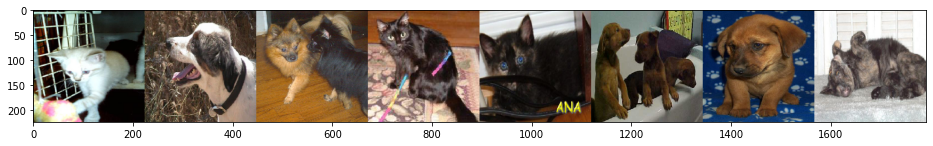

In [59]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

Primeiro treinamento de uma rede neural do zero.

In [61]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 activation_12 (Activation)  (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_13 (Activation)  (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                 

Criamos uma rede de tamanho médio com aproximadamente 1,2 milhão de pesos e vieses (os parâmetros). A maioria deles está levando para a camada pré-softmax totalmente conectada "dense_5".

Agora podemos prosseguir e treinar nosso modelo para 100 épocas com um tamanho de lote de 128. Também registraremos seu histórico para que possamos plotar a perda ao longo do tempo posteriormente.

In [62]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
3/3 [==============================] - 42s 12s/step - loss: 0.9130 - accuracy: 0.4638 - val_loss: 0.6986 - val_accuracy: 0.5750
Epoch 2/10
3/3 [==============================] - 24s 8s/step - loss: 0.7237 - accuracy: 0.4826 - val_loss: 0.7120 - val_accuracy: 0.5875
Epoch 3/10
3/3 [==============================] - 24s 8s/step - loss: 0.6970 - accuracy: 0.5818 - val_loss: 0.7135 - val_accuracy: 0.5750
Epoch 4/10
3/3 [==============================] - 26s 9s/step - loss: 0.6983 - accuracy: 0.5871 - val_loss: 0.7235 - val_accuracy: 0.5750
Epoch 5/10
3/3 [==============================] - 24s 8s/step - loss: 0.6781 - accuracy: 0.5845 - val_loss: 0.6967 - val_accuracy: 0.5750
Epoch 6/10
3/3 [==============================] - 24s 8s/step - loss: 0.6670 - accuracy: 0.5925 - val_loss: 0.6781 - val_accuracy: 0.5875
Epoch 7/10
3/3 [==============================] - 24s 8s/step - loss: 0.6657 - accuracy: 0.6005 - val_loss: 0.6693 - val_accuracy: 0.5875
Epoch 8/10
3/3 [=================

Vamos plotar a perda de validação e a precisão da validação ao longo do tempo.

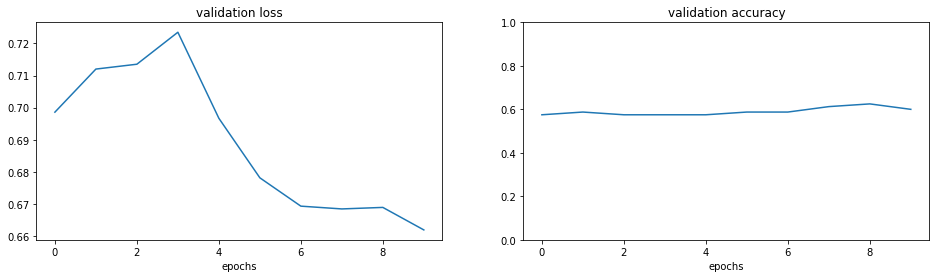

In [70]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Também podemos obter uma avaliação final executando nosso modelo no conjunto de treinamento. Fazendo isso, obtemos os seguintes resultados:

In [71]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.6762731671333313
Test accuracy: 0.604938268661499


Finalmente, vemos que alcançamos uma precisão (top-1) de cerca de 49%. Isso não é tão ruim para 6.000 imagens, considerando que, se usássemos uma estratégia ingênua de fazer suposições aleatórias, teríamos apenas cerca de 1% de precisão.

Transferindo o aprendizado começando com a rede existente
Agora podemos passar para a estratégia principal para treinar um classificador de imagens em nosso pequeno conjunto de dados: começando com uma rede maior e já treinada.


In [72]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Treino


In [73]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

Vamos treinar novamente esta rede, model_new no novo conjunto de dados e labels. Mas, primeiro, precisamos congelar os pesos e vieses em todas as camadas da rede, exceto nossa nova no final, com a expectativa de que os recursos aprendidos no VGG ainda sejam bastante relevantes para a nova tarefa de classificação de imagens. Não é ideal, mas provavelmente melhor do que podemos treinar em nosso conjunto de dados limitado

In [74]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

Como antes, vamos em frente e treinamos o novo modelo, usando os mesmos hiperparâmetros (tamanho do lote e número de épocas) de antes, juntamente com o mesmo algoritmo de otimização. Também acompanhamos sua história à medida que avançamos.

In [75]:
history2 = model_new.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=10, 
                         validation_data=(x_val, y_val))


Epoch 1/10
3/3 [==============================] - 247s 87s/step - loss: 1.3958 - accuracy: 0.2895 - val_loss: 1.1411 - val_accuracy: 0.5750
Epoch 2/10
3/3 [==============================] - 240s 86s/step - loss: 0.8307 - accuracy: 0.6247 - val_loss: 0.8095 - val_accuracy: 0.4500
Epoch 3/10
3/3 [==============================] - 258s 93s/step - loss: 0.8183 - accuracy: 0.4504 - val_loss: 0.5540 - val_accuracy: 0.8250
Epoch 4/10
3/3 [==============================] - 250s 91s/step - loss: 0.6801 - accuracy: 0.6300 - val_loss: 0.7044 - val_accuracy: 0.5750
Epoch 5/10
3/3 [==============================] - 247s 89s/step - loss: 0.6021 - accuracy: 0.6461 - val_loss: 0.5433 - val_accuracy: 0.7250
Epoch 6/10
3/3 [==============================] - 246s 87s/step - loss: 0.6037 - accuracy: 0.6408 - val_loss: 0.4951 - val_accuracy: 0.7375
Epoch 7/10
3/3 [==============================] - 274s 101s/step - loss: 0.4828 - accuracy: 0.7721 - val_loss: 0.5288 - val_accuracy: 0.6000
Epoch 8/10
3/3 [===

Vamos plotar a perda de validação e a precisão novamente, desta vez comparando o modelo original treinado do zero (em azul) e o novo modelo aprendido por transferência em verde.

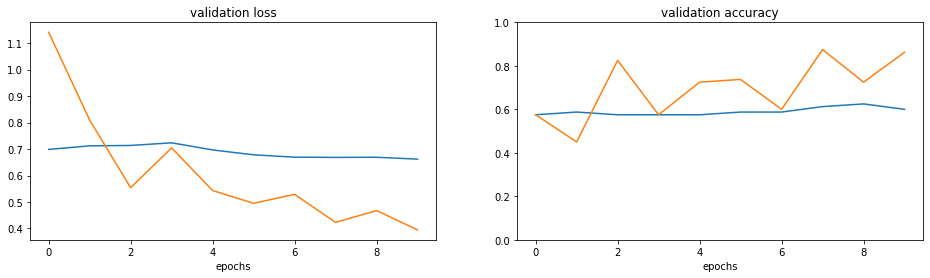

In [76]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

 O novo modelo alcançou cerca de 85% de precisão no primeiro lugar (no conjunto de validação) e continuou a melhorar lentamente ao longo do tempo.

In [77]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.42580047249794006
Test accuracy: 0.8518518805503845


Para prever uma nova imagem, basta executar o código a seguir para obter as probabilidades de cada classe.

In [81]:
img, x = get_image('101_ObjectCategories/Cats/1239.jpg')
probabilities = model_new.predict([x])
print(probabilities)

1/1 [==============================] - 1s 573ms/step
[[4.8697157e-09 3.2238025e-04 9.9967766e-01]]
